# Simulating single component Lennard-Jones with rumdpy 

Features included:
- choice between several integrators
- cooling ramp giving insight into phase behavior
- on-the-fly 3D visualization

In [1]:
# Reproducing 'ATU' run in phd1:
#    LJ, N=864, rho=0.60, cooling from T=3.0 to 0.1 with dt=0.005, 
#    scalars: every 20'th step, trajectory: 194 log-blocks )    
#
# Timestep                                       200_000        2_000_000
# Rumd3 GeForce GTX TITAN, 5.5 TFlops, runtime: 56   sec        196   sec
# rumdpy RTX 3070 Laptop, 11.4 TFlops, runtime:  8.2 (4.7) sec   41.0 (37.1) sec (trajectories not yet included)

## Imports

In [1]:
import numpy as np
import numba
from numba import cuda

# rumdpy
import rumdpy as rp
from rumdpy.integrators import nve, nve_toxvaerd, nvt, nvt_langevin, npt_langevin
from analyze_LJ import analyze_LJ

# IO
import pandas as pd
import pickle
import sys

# Plotting and visualization
import matplotlib.pyplot as plt
#%matplotlib inline
#%matplotlib notebook
%matplotlib widget

import k3d
from k3d.colormaps import matplotlib_color_maps


## Generate configuration with a FCC lattice

In [24]:
c1 = rp.make_configuration_fcc(nx=6,  ny=6,  nz=6,  rho=0.60,  T=3.44)      # N = 4*6**3  =  864
#c1 = rp.make_configuration_fcc(nx=24,  ny=4,  nz=4,  rho=0.60,  T=3.44)      # 
#c1 = rp.make_configuration_fcc(nx=10,  ny=10,  nz=10,  rho=0.60,  T=3.44)  # N = 4*10**3 = 4096
c1.copy_to_device() 

# Get a 'compute-plan', i.e. parameters determining how simulations are performed on the GPU
compute_plan = rp.get_default_compute_plan(c1)
print('compute_plan:', compute_plan)

compute_plan: {'pb': 8, 'tp': 16, 'skin': 0.5, 'UtilizeNIII': False, 'gridsync': True}


## Setup Lennard-Jones pair potential

In [25]:
pair_potential = rp.apply_shifted_force_cutoff(rp.make_LJ_m_n(12,6))
params = [[[4.0, -4.0, 2.5],], ]
LJ = rp.PairPotential(c1, pair_potential, params=params, max_num_nbs=1000, compute_plan=compute_plan)
pairs = LJ.get_interactions(c1, exclusions=None, compute_plan=compute_plan, verbose=True)

Setting up pair interactions for 864 particles in 3 dimensions:
	compute_plan: {'pb': 8, 'tp': 16, 'skin': 0.5, 'UtilizeNIII': False, 'gridsync': True}
	parameters:
[[[ 4.  -4.   2.5]]]
	pb: 8, tp:16, num_blocks:108
	Number (virtual) particles: 864
	Number of threads 13824


## Setup output manager

In [26]:
### MOVE to rumdpy

def make_output_calculator(configuration, steps_between_output, compute_plan=compute_plan, verbose=False):
    D = configuration.D
    num_part = configuration.N
    pb = compute_plan['pb']
    tp = compute_plan['tp']
    gridsync = compute_plan['gridsync']
    UtilizeNIII = compute_plan['UtilizeNIII']
    num_blocks = (num_part-1)//pb + 1
    
    # Unpack indicies for vectors and scalars    
    #for key in configuration.vid:
    #    exec(f'{key}_id = {configuration.vid[key]}', globals())
    for col in configuration.vectors.column_names:
        exec(f'{col}_id = {configuration.vectors.indicies[col]}', globals())
    for key in configuration.sid:
        exec(f'{key}_id = {configuration.sid[key]}', globals())
 
    
    def output_calculator(grid, vectors, scalars, r_im, sim_box,  output_array, step):
        """     
        """

        if step%steps_between_output==0:
            save_index = step//steps_between_output
        
            my_block = cuda.blockIdx.x
            local_id = cuda.threadIdx.x
            global_id = my_block * pb + local_id
            my_t = cuda.threadIdx.y

            if global_id < num_part and my_t == 0:
                cuda.atomic.add(output_array, (save_index, 0), scalars[global_id][u_id])   # Potential energy
                cuda.atomic.add(output_array, (save_index, 1), scalars[global_id][w_id])   # Virial
                cuda.atomic.add(output_array, (save_index, 2), scalars[global_id][lap_id]) # Laplace
                cuda.atomic.add(output_array, (save_index, 3), scalars[global_id][fsq_id]) # F**2
                cuda.atomic.add(output_array, (save_index, 4), scalars[global_id][k_id])   # Kinetic energy
                if global_id ==0:
                    output_array[save_index,5] = vectors[r_id][global_id,0]   # x
                    output_array[save_index,6] = vectors[r_id][global_id,1]   # y
                    output_array[save_index,7] = vectors[r_id][global_id,2]   # z
            
        return
    return output_calculator

In [27]:
steps_between_output = 20
output_calculator = make_output_calculator(c1, steps_between_output, compute_plan)

## Setup RDF (Radial distribution) calculator

In [28]:
include_rdf = True
if include_rdf:
    num_bins = 500
    full_range=True
    gr_bins = np.zeros(num_bins, dtype=np.float64)
    d_gr_bins = cuda.to_device(gr_bins)
    host_array_zeros = np.zeros(d_gr_bins.shape, dtype=d_gr_bins.dtype)
    rdf_calculator = rp.make_rdf_calculator(c1, pair_potential = LJ, compute_plan=compute_plan, full_range=full_range, verbose=True)  


## Initialize 3D visualization

In [42]:
plt_points = k3d.points(positions=c1['r'],
                        point_sizes=np.ones((c1.N),dtype=np.float32),
                        #shader='3dSpecular',
                        #shader='3d',
                        shader='mesh',
                        color_map=matplotlib_color_maps.Jet,
                        attribute=c1.scalars[:,0],
                        color_range=[-6, 0],
                        name='Atoms'
                       )
Lx, Ly, Lz = c1.simbox.data
print(Lx, Ly, Lz)
plt_box = k3d.lines(vertices=[[-Lx/2, -Ly/2, -Lz/2], [-Lx/2, -Ly/2, +Lz/2], 
                              [-Lx/2, +Ly/2, -Lz/2], [+Lx/2, -Ly/2, -Lz/2], 
                              [-Lx/2, +Ly/2, +Lz/2], [+Lx/2, -Ly/2, +Lz/2], 
                              [+Lx/2, +Ly/2, -Lz/2], [+Lx/2, +Ly/2, +Lz/2]], 
                    indices=[[0,1], [0,2], [0,3], 
                            [1,4], [1,5], [2,4], [2,6], [3,5], [3,6],
                            [7,4], [7,5], [7,6]], 
                    indices_type='segment',
                    shader='mesh', width=min((Lx, Ly, Lz))/100, 
                    name='Simulation Box'
                   )


plt_fn_text = k3d.text2d('Potential energy',
                         position=[0.01, 0.45],
                         is_html=True,
                         reference_point='lc',
                         color=0xff7764)

plot = k3d.plot(camera_mode='orbit', fps=10, minimum_fps=-1, camera_fov=5.0,)
plot += plt_points
plot += plt_box
plot += plt_fn_text
#plot.display()

11.292433 11.292433 11.292433


## Setup integrator

In [48]:
dt = 0.005 # timestep (MOVE from setup to call)
outer_steps = 1_000   # Do simulation in this many 'blocks'
inner_steps = 1_000  # ... each of this many steps

integrator = 'NVT'

# Setup functions to control temperature and pressure (only for NPT)
T0 = rp.make_function_constant(value=2.0) # Not used for NVE*
P0 = rp.make_function_constant(value=0.0) # Not used for NV*
#T1 = rp.make_function_ramp(value0=2.0, x0=0.0, value1=0.01, x1=dt*inner_steps*outer_steps)
T1 = rp.make_function_ramp(value0=2.0, x0=0.0, value1=0.1, x1=dt*inner_steps*outer_steps/2)


In [49]:
# Integrator for equilibration
integrate0, integrator_params0 = nvt.setup_output(c1, pairs['interactions'], None, T0, tau=0.2, dt=dt, compute_plan=compute_plan, verbose=False) 

# Interrator for production
if integrator=='NVE':
    integrate, integrator_params = nve.setup_output(c1, pairs['interactions'], output_calculator, dt=dt, compute_plan=compute_plan, verbose=False)

if integrator=='NVE_Toxvaerd':
    integrate, integrator_params = nve_toxvaerd.setup_output(c1, pairs['interactions'], output_calculator, dt=dt, compute_plan=compute_plan, verbose=False)

if integrator=='NVT':
    integrate, integrator_params = nvt.setup_output(c1, pairs['interactions'], output_calculator, T1, tau=0.2, dt=dt, compute_plan=compute_plan, verbose=False) 
        
if integrator=='NVT_Langevin':
    integrate, integrator_params = nvt_langevin.setup_output(c1, pairs['interactions'], output_calculator, T1, alpha=0.1, dt=dt, seed=2023, compute_plan=compute_plan, verbose=False)

if integrator=='NPT_Langevin':
    integrate, integrator_params = npt_langevin.setup_output(c1, pairs['interactions'],  output_calculator, T1, P0, alpha=0.1, alpha_baro=0.0001, 
        mass_baro=0.0001, volume_velocity=0.0, barostatModeISO = True , boxFlucCoord = 2, dt=dt, seed=2023, compute_plan=compute_plan, verbose=False)


## Run Simulation 

In [50]:
# Scale to desired density
target_density = 0.60
c1.copy_to_host()
current_density = c1.N/np.prod(c1.simbox.data)
scale_factor = (current_density/target_density)**(1/3)
c1['r'] *= scale_factor
c1.simbox.data *= scale_factor
c1.copy_to_device()

# Store simulation parameters for use in post run analysis
sim_params = {'N':c1.N, 'D':c1.D, 'simbox':c1.simbox.data, 'integrator':integrator, 'rdf':include_rdf}
print('sim_params:', sim_params)
with open('Data/LJ_pdict.pkl', 'wb') as f:
    pickle.dump(sim_params, f)


zero_output_array = np.zeros((inner_steps//steps_between_output, 10), dtype=np.float32)
d_output_array = cuda.to_device(zero_output_array)
integrate0(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data,  
           pairs['interaction_params'], integrator_params0, d_output_array, np.float32(0), inner_steps)

scalars_t = []
tt = []
vol_t = []

start = cuda.event()
end = cuda.event()
zero = np.float32(0.0)
rdf_count = 0
plt_points.color_range=[-6, 0]
plot.display()

start.record() # Exclude first step from timing to get it more precise by excluding time for JIT compiling

for i in range(outer_steps):
    d_output_array = cuda.to_device(zero_output_array) # Set output array to zero. Could probably be done faster
    integrate(c1.d_vectors, c1.d_scalars, c1.d_ptype, c1.d_r_im, c1.simbox.d_data,  pairs['interaction_params'], integrator_params, d_output_array, np.float32(i*inner_steps*dt), inner_steps)
    
    scalars_t.append(d_output_array.copy_to_host())        
    
    c1.simbox.data = c1.simbox.d_data.copy_to_host()
    vol = (c1.simbox.data[0] * c1.simbox.data[1] * c1.simbox.data[2])
    vol_t.append(vol)

    # Update 3D visualizaton
    c1.copy_to_host()
    plt_points.positions = c1['r']
    plt_points.attribute = c1.scalars[:,0]
    Lx, Ly, Lz = c1.simbox.data
    plt_box.vertices=[[-Lx/2, -Ly/2, -Lz/2], [-Lx/2, -Ly/2, +Lz/2], 
                              [-Lx/2, +Ly/2, -Lz/2], [+Lx/2, -Ly/2, -Lz/2], 
                              [-Lx/2, +Ly/2, +Lz/2], [+Lx/2, -Ly/2, +Lz/2], 
                              [+Lx/2, +Ly/2, -Lz/2], [+Lx/2, +Ly/2, +Lz/2]],
    
    if i>outer_steps//2 and include_rdf:                 # Only do RDF second half of simulation
        rdf_count += 1
        rdf_calculator(c1.d_vectors, c1.simbox.d_data, c1.d_ptype, pairs['interaction_params'], d_gr_bins)
        temp_host_array = d_gr_bins.copy_to_host()       # offloading data from device and resetting decive array to zero. 
        gr_bins += temp_host_array                       # ... (prevents overflow errors for longer runs)  
        d_gr_bins = cuda.to_device(host_array_zeros)

end.record()
end.synchronize()
timing_numba = cuda.event_elapsed_time(start, end)
nbflag = LJ.nblist.d_nbflag.copy_to_host()    
tps = outer_steps*inner_steps/timing_numba*1000
output_array = d_output_array.copy_to_host()
#print(np.mean(output_array, axis=0))
#print(output_array[0:20,:])

print('\tsteps :', outer_steps*inner_steps)
print('\tnbflag : ', nbflag)
print('\ttime :', timing_numba/1000, 's')
print('\tTPS : ', tps )
print('\tfinal box dims : ', c1.simbox.data[0], c1.simbox.data[1], c1.simbox.data[2])


sim_params: {'N': 864, 'D': 3, 'simbox': array([11.292433, 11.292433, 11.292433], dtype=float32), 'integrator': 'NVT', 'rdf': True}


Output()

	steps : 1000000
	nbflag :  [     0      0 253486]
	time : 21.87355859375 s
	TPS :  45717.29815768217
	final box dims :  11.292433 11.292433 11.292433


In [51]:
plt_fn_text.text = 'u'
attribute = c1.scalars[:,0]
print(np.mean(attribute), np.std(attribute))
plt_points.attribute = attribute
plt_points.color_range=[min(attribute), max(attribute)]

-5.8706117 0.98500377


In [52]:
scalars_t = np.concatenate(scalars_t)

# Save data
df = pd.DataFrame(scalars_t, columns=['u', 'w', 'lap', 'fsq', 'k', 'x0', 'y0', 'z0', 'd', 'd'])
df['t'] = np.array(np.arange(scalars_t.shape[0])*dt*steps_between_output)
df['vol'] = vol_t[0]
if integrator[0:3]!='NVE':
    df['Ttarget'] = numba.vectorize(T1)(np.array(df['t']))
if integrator=='NPT_Langevin':
    df['Ptarget'] = numba.vectorize(P0)(np.array(df['t'])) 
    #df['vol'] = np.array(vol_t)


print(df.mean())
df.to_csv('Data/LJ_scalars.csv')

if include_rdf:
    data = rp.normalize_and_save_gr(gr_bins, c1, pairs['interaction_params'], 
                                    full_range, rdf_count, filename='Data/LJ_rdf.dat')


u           -4123.883301
w            -333.847046
lap        565550.187500
fsq        290163.187500
k             744.438965
x0              1.491261
y0             -2.572730
z0              0.091989
d               0.000000
d               0.000000
t            2499.950000
vol          1440.000122
Ttarget         0.575019
dtype: float64


pdict:  {'N': 864, 'D': 3, 'simbox': array([11.292433, 11.292433, 11.292433], dtype=float32), 'integrator': 'NVT', 'rdf': True}


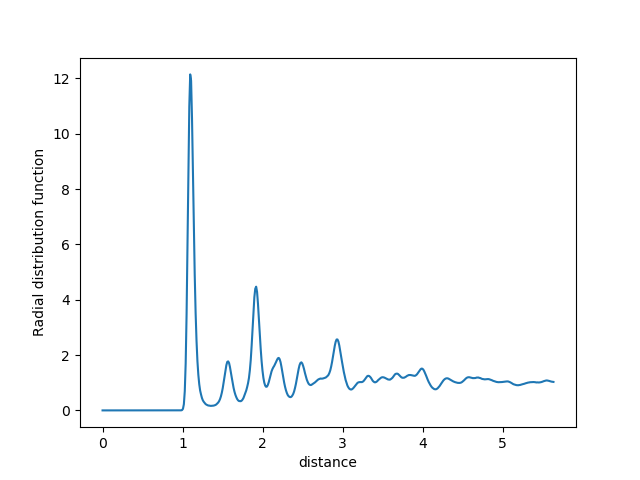

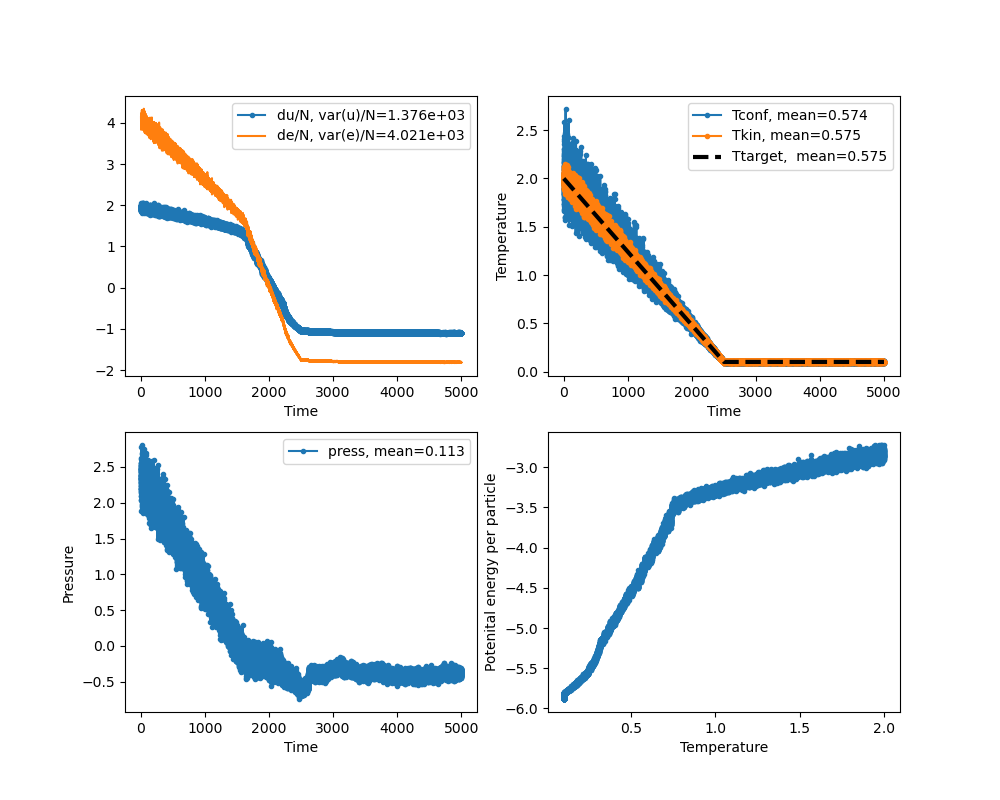

In [53]:
analyze_LJ()